In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from koala.example_graphs import generate_hex_square_oct,generate_honeycomb,generate_tri_non
from koala.graph_color import color_lattice
from koala.pointsets import generate_bluenoise
from koala.voronization import generate_lattice
from koala.graph_color import color_lattice
from koala.plotting import plot_lattice, peru_friendly_colour_scheme
import koala.plotting as pl

first we look at 4 examples of small systems

In [32]:

honeycomb = generate_honeycomb(4,True)

hex_squre_oct = generate_hex_square_oct(2)
hso_colouring = color_lattice(hex_squre_oct)

three_nine = generate_tri_non([2,3], True)

points = generate_bluenoise(30,4,4)
amorphous = generate_lattice(points)
am_colouring = color_lattice(amorphous)

lattice_systems = [
    honeycomb[0],
    hex_squre_oct,
    three_nine[0],
    amorphous
]

colourings = [
    honeycomb[1],
    hso_colouring,
    three_nine[1],
    am_colouring
]

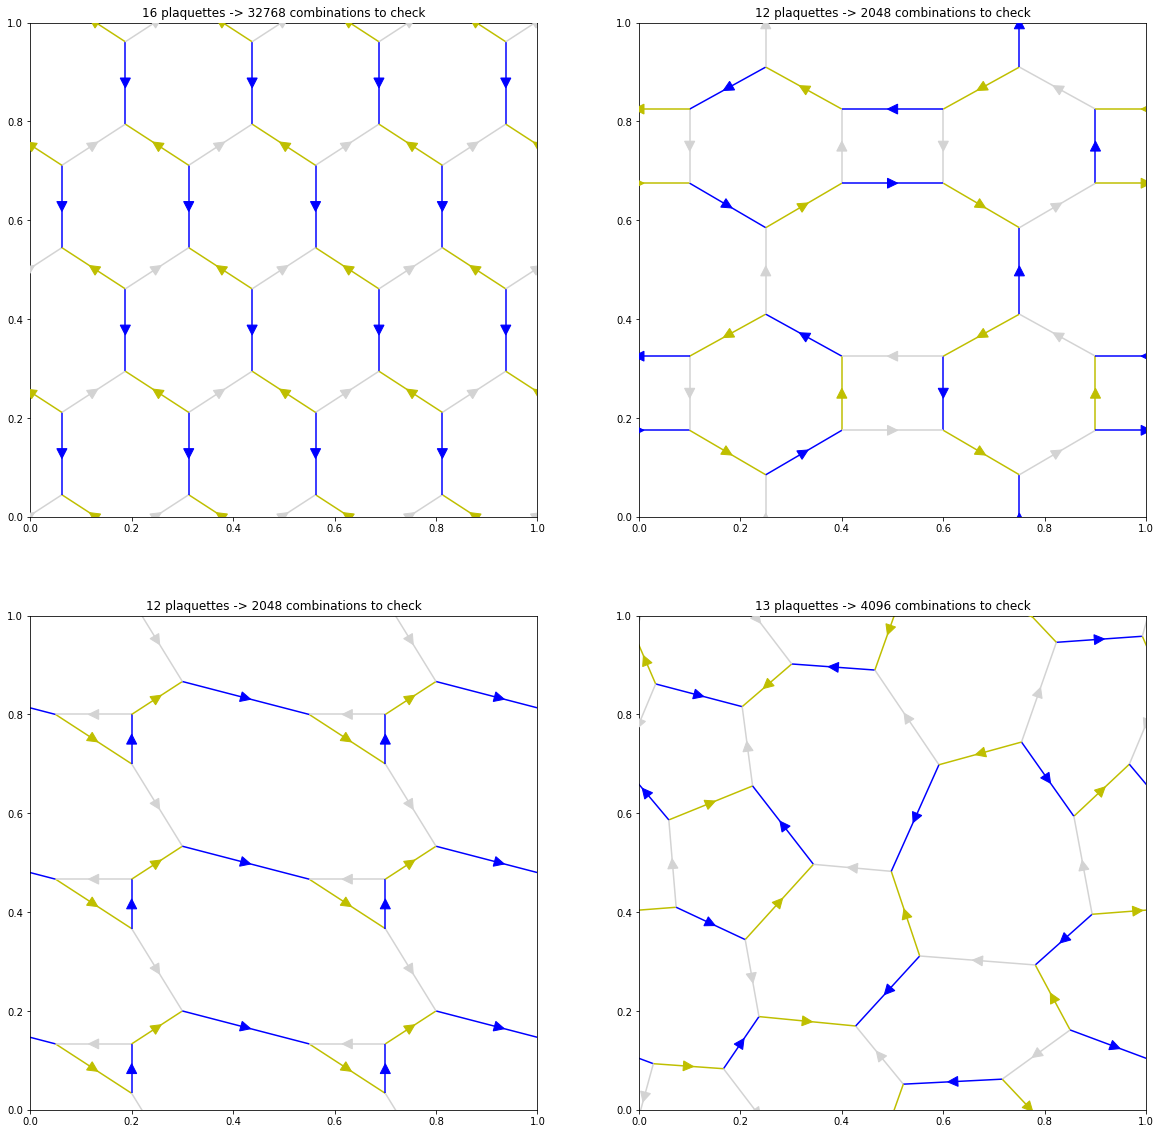

In [34]:
colour_scheme = peru_friendly_colour_scheme(3)

n_systems = len(lattice_systems)
plot_sides = int(np.ceil(n_systems/2))

fig, axes = plt.subplots(2, plot_sides, figsize = (20,10*plot_sides))

for n,lattice in enumerate(lattice_systems):
    ax = axes.flatten()[n]
    plot_lattice(lattice, ax= ax, edge_labels=colourings[n], edge_color_scheme= colour_scheme, edge_arrows = True)
    ax.set_title(f'{lattice.n_plaquettes} plaquettes -> {2**(lattice.n_plaquettes-1)} combinations to check')


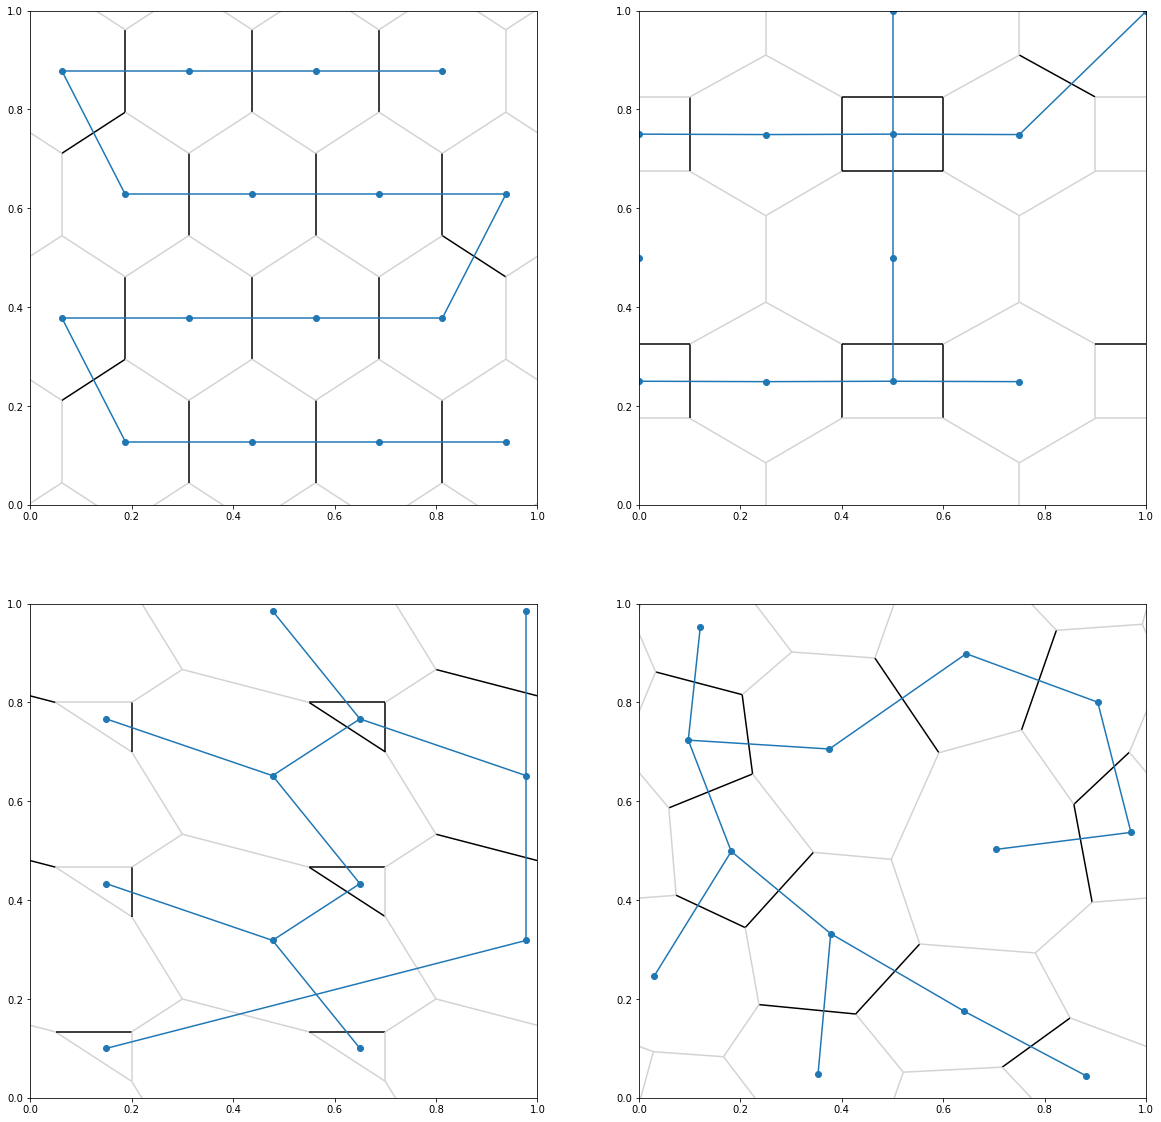

In [88]:
from koala.graph_utils import plaquette_spaning_tree
from matplotlib.collections import LineCollection

spanning_trees = [plaquette_spaning_tree(lat) for lat in lattice_systems]

fig, axes = plt.subplots(2, plot_sides, figsize = (20,10*plot_sides))


for n, lattice in enumerate(lattice_systems):
    ax = axes.flatten()[n]
    edges_in_tree = spanning_trees[n]

    highlight_colouring = np.zeros(lattice.n_edges, dtype = 'int')
    highlight_colouring[edges_in_tree] = 1
    plot_lattice(lattice, ax= ax, edge_labels=highlight_colouring, edge_color_scheme=['lightgrey', 'k'])

    centers = np.array([p.center for p in lattice.plaquettes])
    ax.scatter(centers[:,0], centers[:,1])

    lines = np.zeros((len(edges_in_tree), 2, 2))

    for n,edge in enumerate(edges_in_tree):
        plaquettes = lattice.edges.adjacent_plaquettes[edge]
        centre = np.zeros((2,2))
        centre[0,:] = lattice.plaquettes[plaquettes[0]].center
        centre[1,:] = lattice.plaquettes[plaquettes[1]].center
        lines[n] = centre


    lc = LineCollection(lines)
    ax.add_collection(lc)



In [90]:
from koala.lattice import Lattice

def construct_Ajk(lattice: Lattice, edge_colouring: np.ndarray, ujk: np.ndarray, J_values: np.ndarray):
    """construct the A matrix that the hamiltonian uses

    :param lattice: system to construct the matrix on
    :type lattice: Lattice
    :param edge_colouring: colouring for the edges must be a set of ±1 values
    :type edge_colouring: np.ndarray
    :param ujk: bond signs
    :type ujk: np.ndarray
    :param J_values: j values
    :type J_values: np.ndarray
    :return: the A matrix
    :rtype: np.ndarray
    """
    edge_type_list = J_values[edge_colouring]
    bond_values = 2*edge_type_list*ujk

    ham = np.zeros((lattice.n_vertices, lattice.n_vertices))
    ham[lattice.edges.indices[:,1], lattice.edges.indices[:,0]] = bond_values
    ham[lattice.edges.indices[:,0], lattice.edges.indices[:,1]] = -bond_values

    return ham

def find_ground_state_energy(lattice: Lattice, edge_colouring: np.ndarray, ujk: np.ndarray, J_values: np.ndarray):
    ham = construct_Ajk(lattice,edge_colouring,ujk,J_values)
    energies = np.linalg.eigvalsh(1j*ham)
    energy = -np.sum(np.abs(energies))/4
    return energy



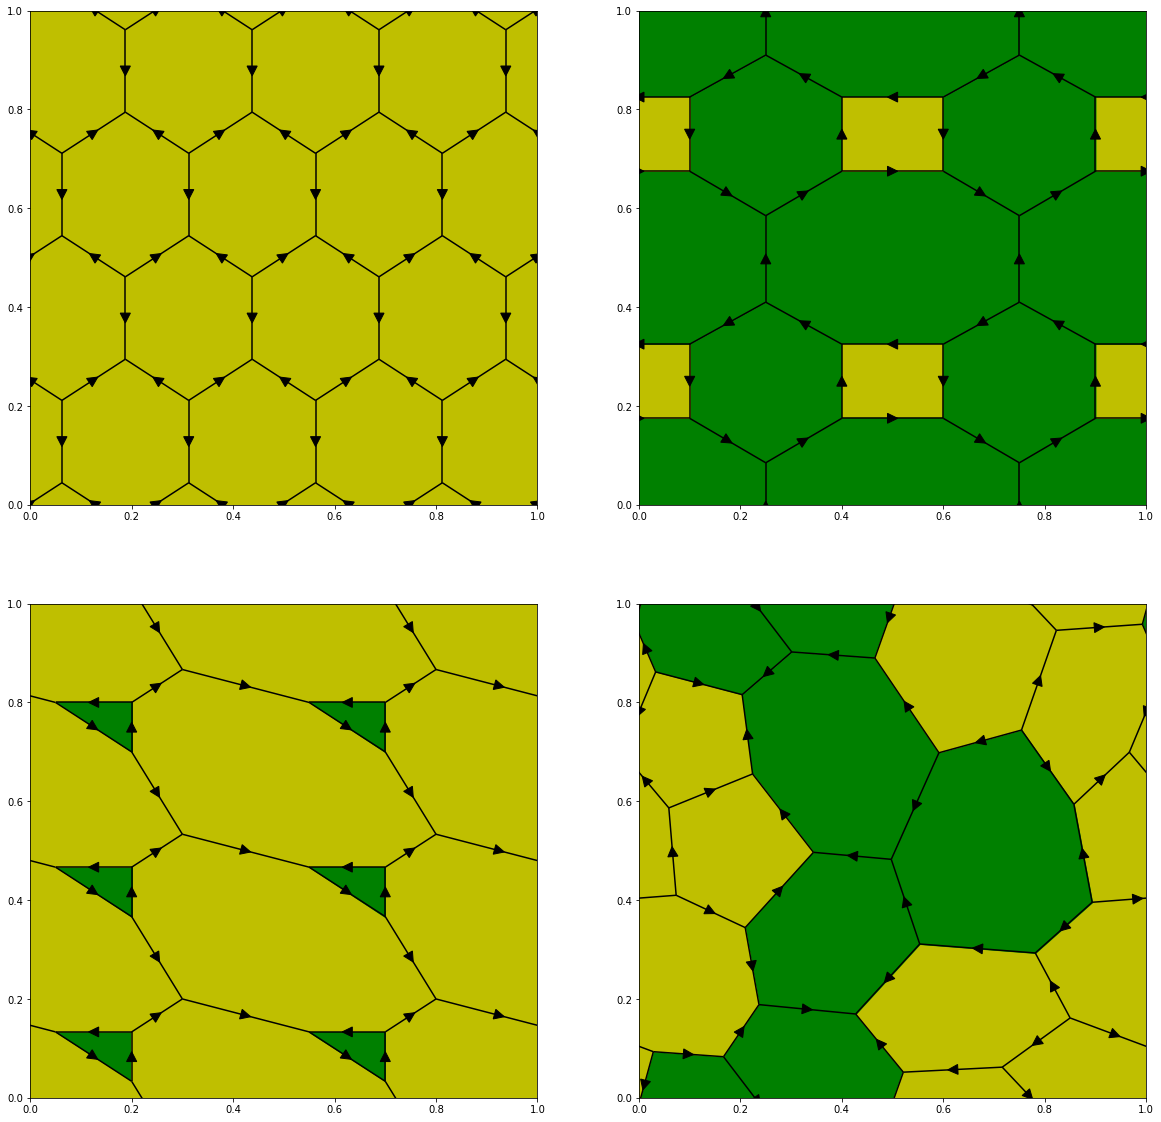

In [92]:
from koala.flux_finder import fluxes_to_labels, fluxes_from_bonds

# now set default ujk values for all of them
ujk_values = []
for lattice in lattice_systems:
    ujk = np.full(lattice.n_edges, 1)
    ujk_values.append(ujk)

# and plot the fluxes for all the graphs
fluxes = []
for n, lattice in enumerate(lattice_systems):
    fluxes.append( fluxes_from_bonds(lattice,ujk_values[n]))

fig, axes = plt.subplots(2, plot_sides, figsize = (20,10*plot_sides))

for n, lattice in enumerate(lattice_systems):
    ax = axes.flatten()[n]
    pl.plot_lattice(lattice, ax=ax, edge_arrows = True)
    pl.plot_plaquettes(lattice, fluxes_to_labels(fluxes[n]), ax= ax,color_scheme=['y', 'g'])


# IGNORE PAST HERE


In [93]:
J_vals = np.array([1,.1,.1])

all_energies = []


def int_to_u_values(num, ujk_base, spanning_tree):

    width = len(spanning_tree)
    string_version = np.binary_repr(num,width = width)
    flip_key = np.array([int(x) for x in string_version])
    index_flips = np.where(flip_key)[0]
    edges_to_flip = spanning_tree[index_flips]
    
    ujk_out = ujk_base.copy()
    ujk_out[edges_to_flip] = -1
    return ujk_out

for n,system in enumerate(lattice_systems):
    print(n)
    e_vals = np.zeros(2**len(spanning_trees[n]))

    for a in range(2**len(spanning_trees[n])):
        
        ujk_for_run = int_to_u_values(a, ujk_values[n], spanning_trees[n])
        


        energy = find_ground_state_energy(system, colourings[n],ujk_for_run,J_vals)
        e_vals[a] = energy
    all_energies.append(e_vals)

    

0
1
2
3


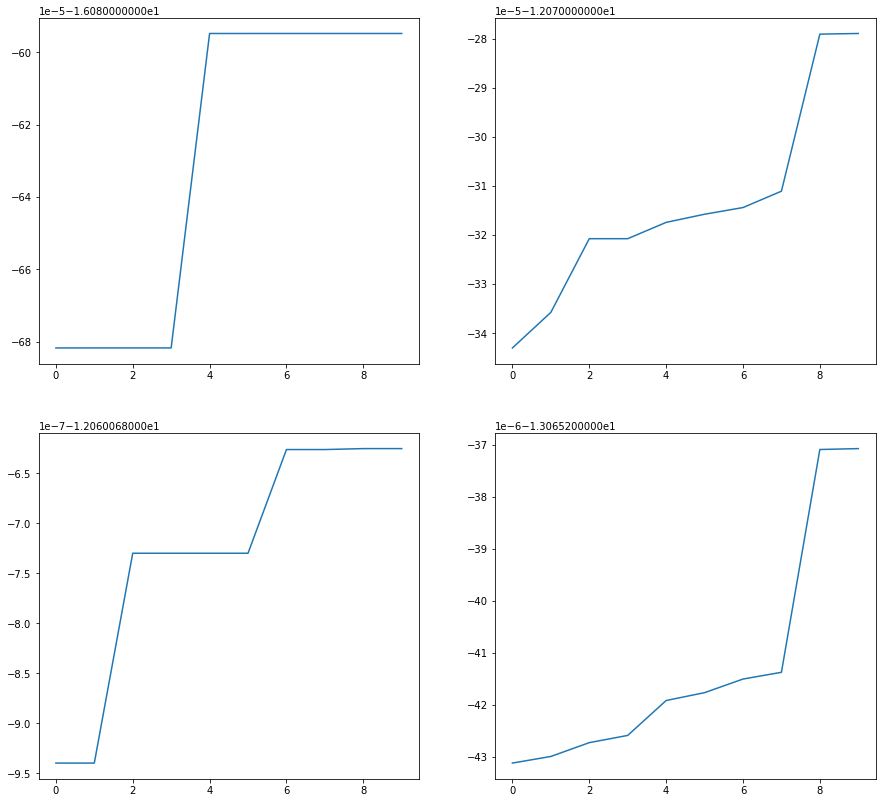

In [94]:
fig, axes = plt.subplots(2, plot_sides, figsize = (15,7*plot_sides))

for n, lattice in enumerate(lattice_systems):
    axes.flatten()[n].plot(sorted(all_energies[n])[:10])


[32760  1147   248   577]


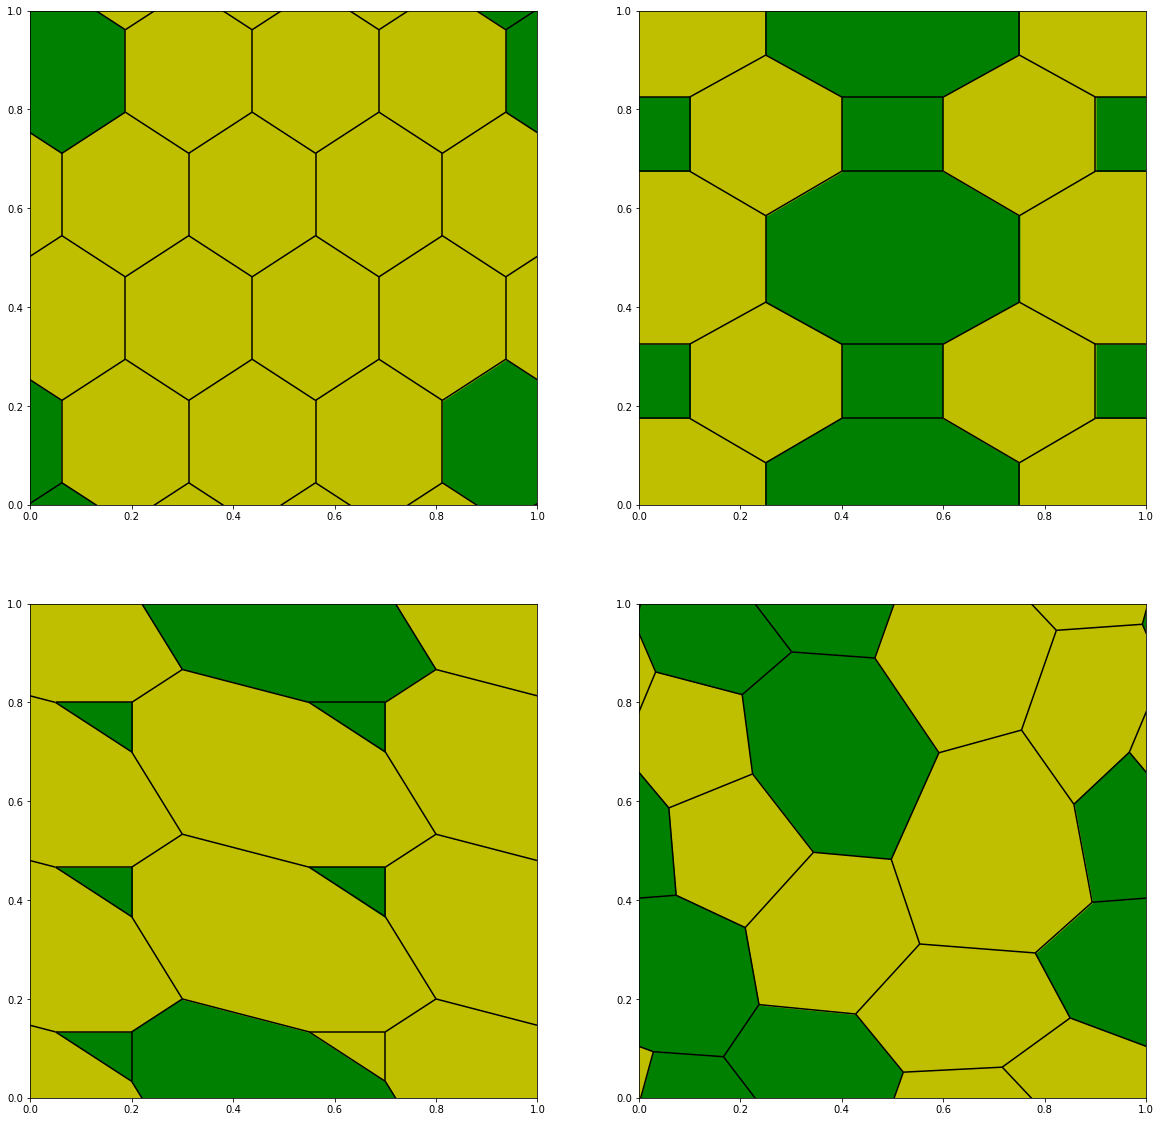

In [96]:
winning_indices = np.array([np.argmin(en) for en in all_energies]) #np.array([np.where(en == en.min())[0] for en in all_energies])
print(winning_indices)
winning_ujks = []
for n, index  in enumerate(winning_indices.flatten()):
    winning_ujks.append( int_to_u_values(index,ujk_values[n], spanning_trees[n]) )



# and plot the fluxes for all the minima of energy
fluxes = []
for n, lattice in enumerate(lattice_systems):
    fluxes.append( fluxes_from_bonds(lattice,winning_ujks[n]))

fig, axes = plt.subplots(2, plot_sides, figsize = (20,10*plot_sides))

for n, lattice in enumerate(lattice_systems):

    

    ax = axes.flatten()[n]
    pl.plot_lattice(lattice, ax=ax)
    pl.plot_plaquettes(lattice, fluxes_to_labels(fluxes[n]), ax= ax,color_scheme=['y', 'g'])



[0, 0, 0, 0]

array([0, 5])